# Neural forecasting models

We will cover neural models for time series forecasting, both trained from scratch and pretrained. We will use varied libraries, depending on the model, for example:
- [sktime](https://www.sktime.net/en/stable/index.html) - general time series processing
- [neuralforecast](https://github.com/Nixtla/neuralforecast) - a lot of neural models for time series, e.g. DLinear, N-BEATS
- [PyTorch](https://pytorch.org/) - deep learning framework
- [timesfm](https://github.com/google-research/timesfm) - official TimesFM implementation (and loading pretrained model)

Use tutorials, quickstarts, GitHub pages etc. of those libraries as necessary.

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Datasets and evaluation

We will use 2 datasets:
1. [Italian pasta dataset](https://www.sciencedirect.com/science/article/abs/pii/S0957417421005431?via%3Dihub), same as in the first notebook.
2. [Polish energy production data](https://energy.instrat.pl/en/electrical-system/electricity-production-are/), as published by Energy Instrat and ENTSO-e, from data by PSE (Polskie Sieci Elektroenergetyczne).

Both are multivariate and focused on long-term forecasting.

### Italian pasta

#### Data loading and visualization

This dataset technically multivariate, but it has data from 4 different companies with very different characteristics, so it may have pretty weak cross-series dependencies. We will consider a simplified variant with no exogenous variables.

In [2]:
from sktime.utils.plotting import plot_series


df_pasta = pd.read_csv("italian_pasta.csv")
for num in [1, 2, 3, 4]:
    company_qty_cols = [col for col in df_pasta.columns if col.startswith(f"QTY_B{num}")]
    df_pasta[f"value_B{num}"] = df_pasta[company_qty_cols].sum(axis="columns")

df_pasta = df_pasta.set_index(pd.to_datetime(df_pasta["DATE"])).asfreq("d")
df_pasta = df_pasta[["value_B1", "value_B2", "value_B3", "value_B4"]]
df_pasta

,value_B1,value_B2,value_B3,value_B4
DATE,,,,
2014-01-02,101.0,186.0,32.0,36.0
2014-01-03,136.0,248.0,32.0,27.0
2014-01-04,162.0,264.0,94.0,45.0
2014-01-05,106.0,106.0,18.0,29.0
2014-01-06,47.0,54.0,9.0,11.0
...,...,...,...,...
2018-12-27,203.0,143.0,30.0,39.0
2018-12-28,192.0,187.0,28.0,44.0
2018-12-29,158.0,217.0,44.0,48.0


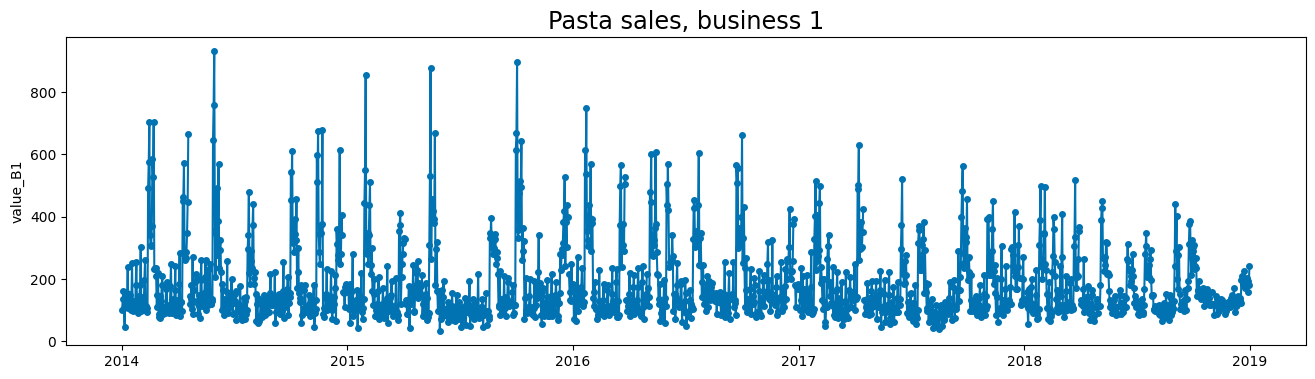

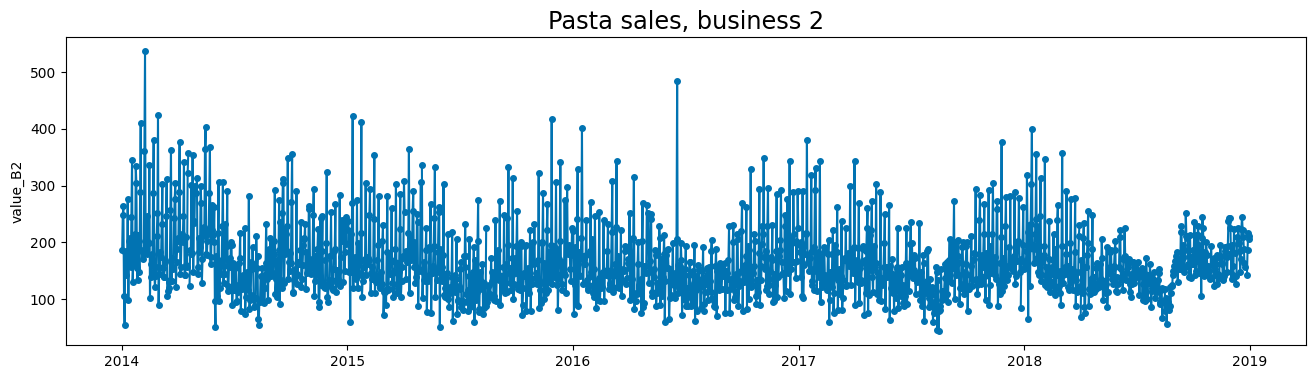

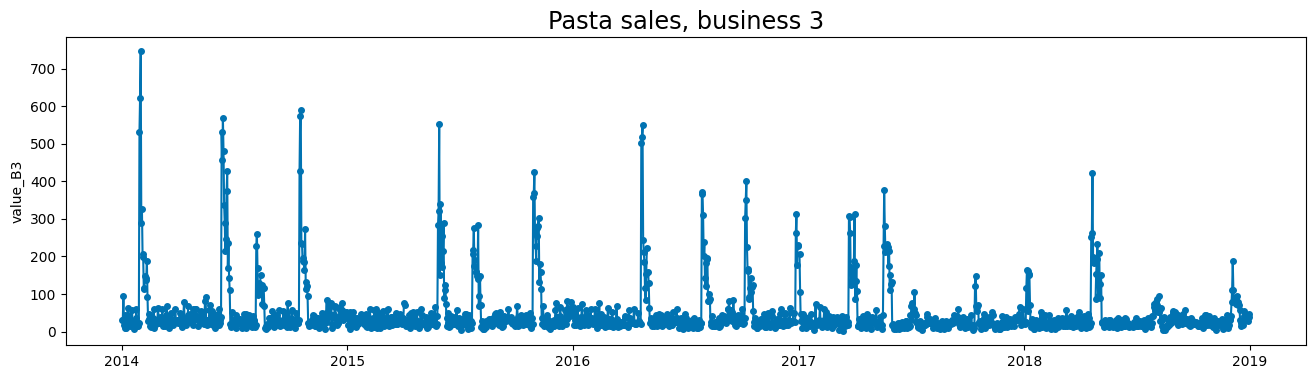

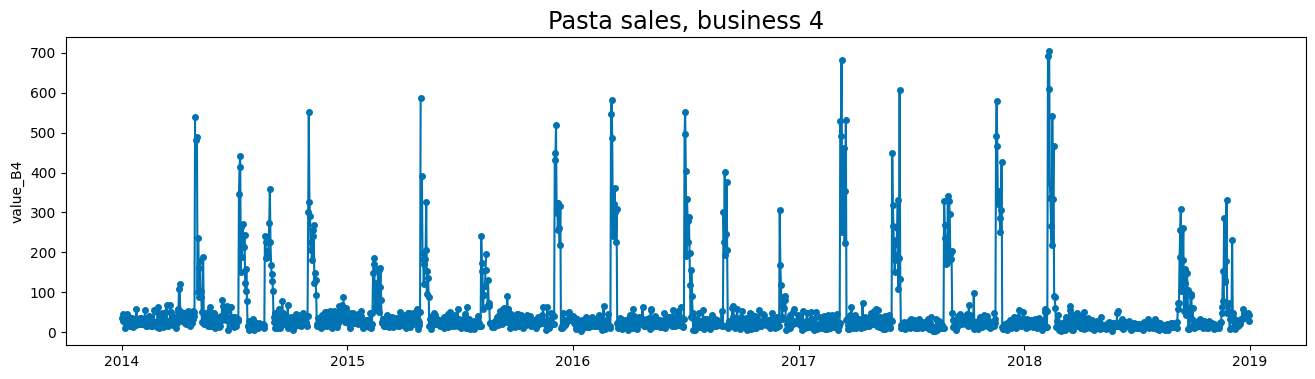

In [3]:
for num in [1, 2, 3, 4]:
    plot_series(df_pasta[f"value_B{num}"], title=f"Pasta sales, business {num}")


#### Evaluation

Similarly to the first notebook, we will be interested in long-term forecasting, predicting the daily sales for 2018, based on previous years. Since we have 4 time series with different scales, MASE is a great metric, since it can be averaged across series.

In [4]:
from sktime.transformations.series.impute import Imputer


df_pasta_train = df_pasta[df_pasta.index < "2018-01-01"]
df_pasta_test = df_pasta[df_pasta.index >= "2018-01-01"]

imputer = Imputer(method="ffill")
df_pasta_train = imputer.fit_transform(df_pasta_train)
df_pasta_test = imputer.transform(df_pasta_test)

print(f"Data size: train {len(df_pasta_train)}, test {len(df_pasta_test)}")

Data size: train 1460, test 365


### Polish energy production

#### Data loading and visualization

Energy mix is composed of multiple energy sources. It typically consists of multiple components:
- slow-changing base, e.g. coal, nuclear
- faster changing and controllable sources, e.g. gas, oil, hydro
- very cheap, but uncontrollably changing renewables, e.g. wind, solar

The resulting production is always limited by the grid efficiency, which is very low in Poland, resulting in e.g. refusing to connect more prosumer solar installations. As such, the production limits are monitored and controlled, and cross-series dependencies are often quite strong.

We will aggregate the energy sources a bit, and consider:
- coal (and derivatives)
- hydro (from all sources)
- solar
- wind
- all others, e.g. oil (petroleum), biomass

Since units are GWh (10^9 Wh, Whatt hours), values are very high, so we will consider thousands of GWh, i.e. TWh (10^12 Wh). It is not a standard unit, but should help with numerical stability for methods that do not perform standardization or scaling.

Data from PSE has changed its format and processing at 13.06.2024, and values since this date are in 15-minutes intervals, compared to 1-hour from before. As such, we divide them by 4, to have the same unit.

If you want to know more about energy production and demand, see e.g. [this video](https://www.youtube.com/watch?v=xhxo2oXRiio) or [this video](https://www.youtube.com/watch?v=GBp_NgrrtPM).

In [5]:
df_energy = pd.read_csv("electricity_production_entsoe_all.csv")
df_energy = df_energy.drop(columns="date_utc")
df_energy["date"] = pd.to_datetime(df_energy["date"], format="%d.%m.%Y %H:%M")
df_energy = df_energy.set_index("date")
df_energy = df_energy.resample("D").sum()

# aggregate energy sources
df_energy["coal"] = (
    df_energy["hard_coal"] + df_energy["coal-derived"] + df_energy["lignite"]
)
df_energy["hydro"] = (
    df_energy["hydro_pumped_storage"] + 
    df_energy["hydro_run-of-river_and_poundage"] + 
    df_energy["hydro_water_reservoir"]
)
df_energy["wind"] = df_energy["wind_onshore"]
df_energy["other"] = (
    df_energy["oil"] + 
    df_energy["biomass"] + 
    df_energy["other"] + 
    df_energy["other_renewable"]
)
df_energy = df_energy[["coal", "gas", "hydro", "wind", "solar", "other"]]

# fix values and change units (GWh -> thousands of GWh)
df_energy[df_energy.index >= "13.06.2024"] /= 4
df_energy["other"][df_energy.index >= "13.06.2024"] /= 2
df_energy = df_energy / 1000

df_energy

,coal,gas,hydro,wind,solar,other
date,,,,,,
2015-01-02,298.90400,10.13800,9.25500,77.61100,0.0000,5.702000
2015-01-03,288.79200,10.25900,9.30400,80.98500,0.0000,5.155000
2015-01-04,271.66200,9.89600,7.83800,77.09600,0.0000,4.175000
2015-01-05,367.48300,10.03000,7.09000,43.30900,0.0000,5.627000
2015-01-06,343.57200,10.26700,7.06800,18.49900,0.0000,5.631000
...,...,...,...,...,...,...
2024-10-30,272.83625,68.80675,4.48175,87.23000,13.5885,16.192750
2024-10-31,252.18300,60.90650,4.63500,111.13200,20.7190,16.189625
2024-11-01,158.76150,43.92125,5.50675,169.88575,23.0975,14.869250


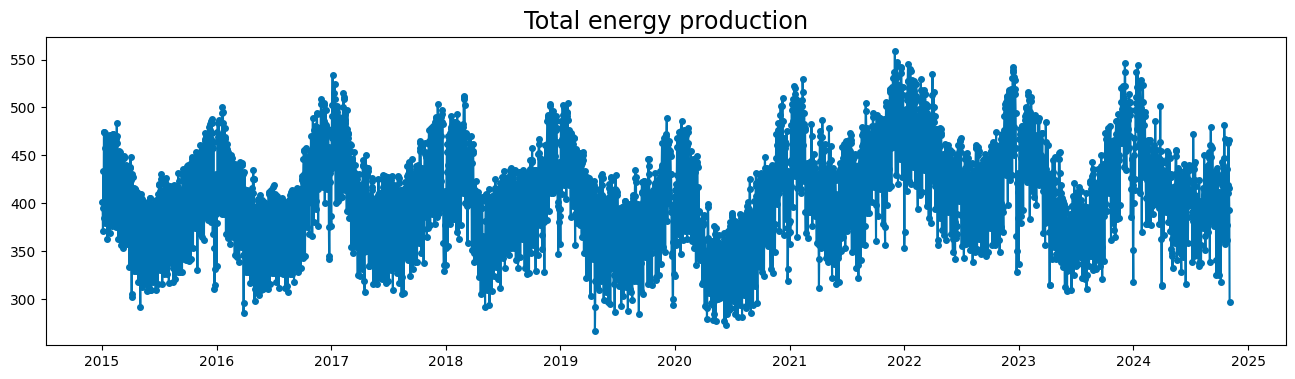

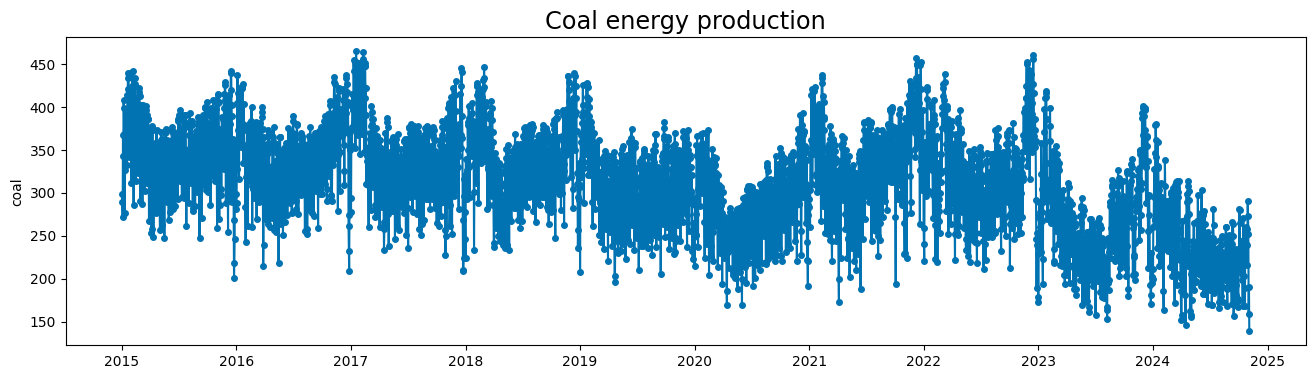

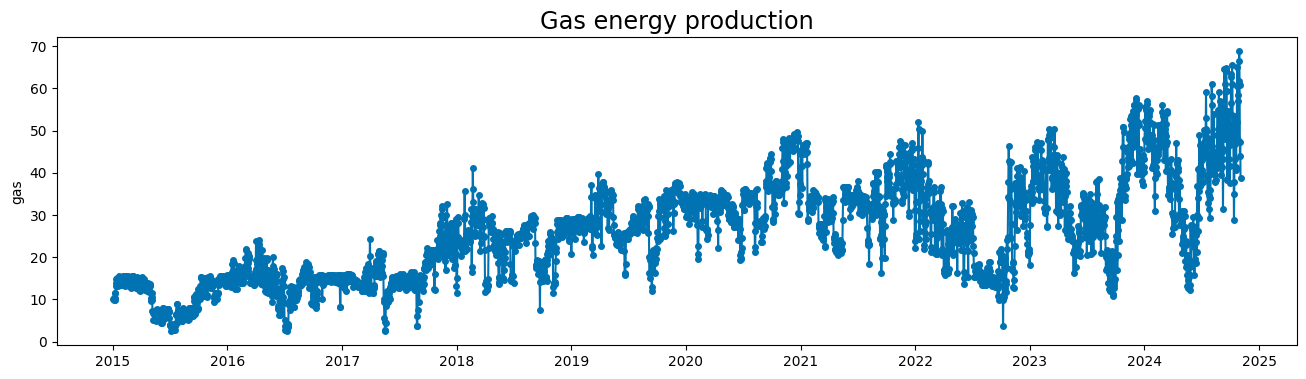

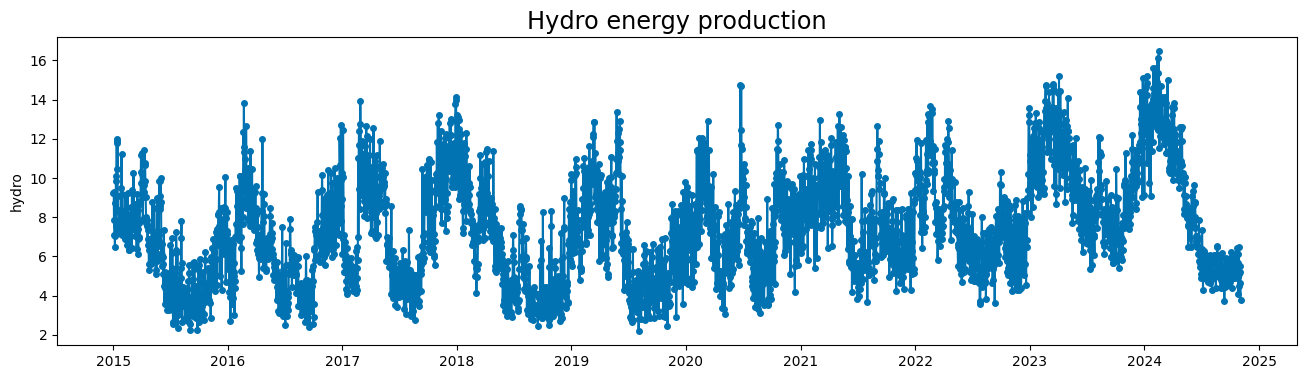

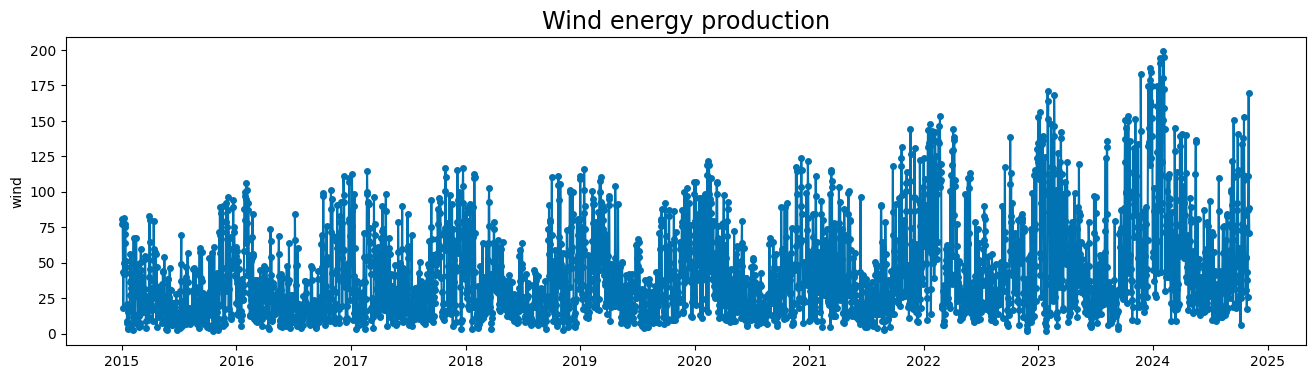

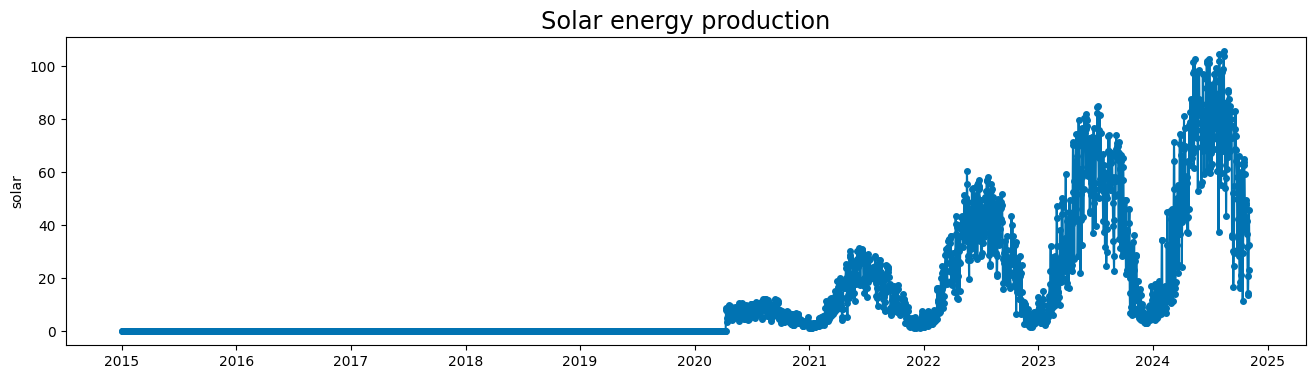

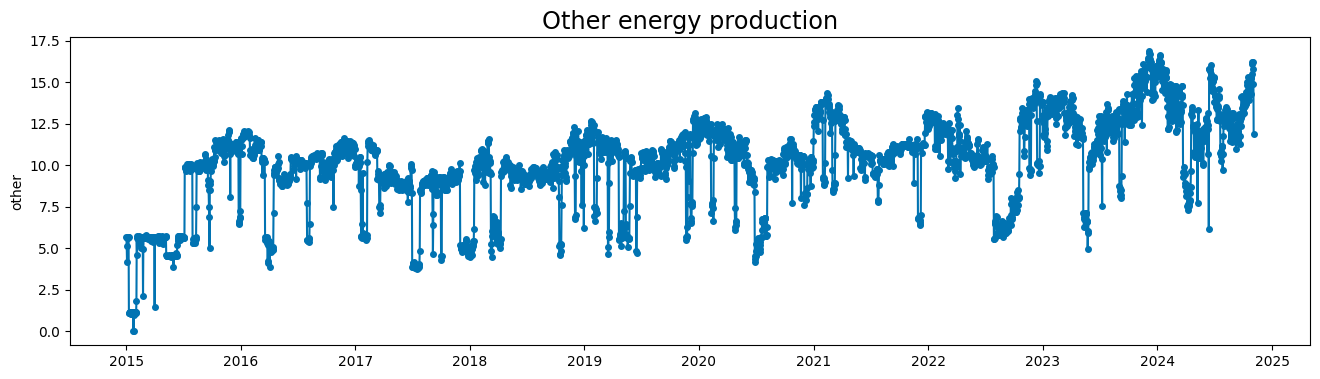

In [6]:
plot_series(df_energy.sum(axis="columns"), title=f"Total energy production")

for col in df_energy.columns:
    plot_series(df_energy[col], title=f"{col.capitalize()} energy production")


#### Evaluation

We will perform long-term forecasting, which is a common task on energy production and demand datasets. We will predict production for 2024, using MASE metric.

In [7]:
from sktime.transformations.series.impute import Imputer


df_energy_train = df_energy[df_energy.index < "2024-01-01"]
df_energy_test = df_energy[df_energy.index >= "2024-01-01"]

print(f"Data size: train {len(df_energy_train)}, test {len(df_energy_test)}")

Data size: train 3286, test 308


## Forecasting

The sub-sections are independent, and can be implemented in any order. The more you do, the more points (and hence the higher mark) you get. They are also more freeform than previous notebook, and there are more options to choose from.

When tuning hyperparameters, choose any strategy you think is reasonable, taking into consideration computational cost and model complexity. Temporal train-valid-test split, time split CV, expanding window - your choice. Even manual tuning is ok, if you think it makes sense, but remember to use the validation set.

You can use any framework and tool you want, but suggestions are provided in further sections. Install additional dependencies as needed, either using Poetry and recreating `poetry lock`, or by directly using `!pip install ...`.

Training and evaluating more models from particular category can get you more points, as described below. If you prefer, you can also experiment with other models, e.g. RNNs, CNN-based, or state-space models (SSMs), adding further sections. Each one by default is worth 2 points.

**Warning:** when making this notebook, some errors with `neuralforecast` cropped up when horizon was greater than 292 for Italian pasta dataset. You can cut the test set at 292 if necessary.

Note that some frameworks (e.g. `neuralforecast`) require "tall"/"long" time series representation, with columns: `unique_id` (time series identifier), `ds` (date) and `y` (actual value). This is in contrast to the "wide" representation, where we have individual series in separate columns, each row with separate date, and values in cells. See e.g. [neuralforecast quickstart](https://nixtlaverse.nixtla.io/neuralforecast/docs/getting-started/quickstart.html#2-loading-airpassengers-data) for an example. Functions prepared below may be useful.

In [8]:
from typing import Optional


def wide_to_long_df(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.melt(df, ignore_index=False).reset_index(names="date")
    df = df.rename(columns={"variable": "unique_id", "date": "ds", "value": "y"})
    return df


def long_to_wide_df(df: pd.DataFrame, values_col: Optional[str] = None) -> pd.DataFrame:
    if "unique_id" not in df.columns:
        df = df.reset_index(names="unique_id")

    values_col = values_col if values_col else df.columns[-1]
    df = pd.pivot(df, columns="unique_id", index="ds", values=values_col)
    return df


### Baselines (2 points)

Implement baselines for neural models:
- last value (naive)
- average
- AutoARIMA
- AutoETS (with damped trend)

Each dataset is worth 1 point. `sktime` will be useful.

---

### Create an evaluation function

In [54]:
from typing import Optional

import numpy as np
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from sktime.transformations.series.impute import Imputer
from scipy.stats import anderson


def evaluate_model(
    model,
    df_train: pd.Series,
    df_test: pd.Series,
    plot_forecasts: bool = False,
) -> None:

    # impute
    imputer = Imputer(method="ffill")
    df_train = imputer.fit_transform(df_train)
    df_test = imputer.transform(df_test) 

    fh = df_test.index

    model.fit(y=df_train)
    predicted_values = model.predict(fh=fh)

    mae = mean_absolute_error(df_test, predicted_values)
    mape = mean_absolute_percentage_error(df_test, predicted_values)
    mase = mean_absolute_scaled_error(df_test, predicted_values, y_train=df_train)

    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}")
    print(f"MASE: {mase:.2f}")

    if plot_forecasts:
        for col in df_test.columns:
            plot_series(df_test[col], predicted_values[col], title=f"{col.capitalize()}")
            plt.show()        

---

### Evaluate Polish energy production data

In [46]:
from sktime.forecasting.naive import NaiveForecaster

mean_forecaster = NaiveForecaster(strategy="mean",window_length=365)

evaluate_model(mean_forecaster,df_energy_train,df_energy_test)

MAE: 20.44
MAPE: 0.49
MASE: 2.20


In [42]:
last_forecaster = NaiveForecaster(strategy="last")

evaluate_model(last_forecaster,df_energy_train,df_energy_test)

MAE: 21.93
MAPE: 0.49
MASE: 2.36


In [47]:
from sktime.forecasting.statsforecast import StatsForecastAutoETS

auto_ets = StatsForecastAutoETS(damped=True)

evaluate_model(auto_ets,df_energy_train,df_energy_test)

MAE: 29.18
MAPE: 0.79
MASE: 3.15


In [48]:
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA

# we assume yearly seasonality in the data
auto_arima = StatsForecastAutoARIMA()

evaluate_model(auto_arima,df_energy_train,df_energy_test)

MAE: 25.65
MAPE: 0.65
MASE: 2.77


---

### Evaluate Italian pasta dataset

In [63]:
mean_forecaster = NaiveForecaster(strategy="mean",window_length=360)

evaluate_model(mean_forecaster,df_pasta_train,df_pasta_test)

MAE: 44.56
MAPE: 1.07
MASE: 1.03


In [56]:
last_forecaster = NaiveForecaster(strategy="last")

evaluate_model(last_forecaster,df_pasta_train,df_pasta_test)

MAE: 36.68
MAPE: 0.53
MASE: 0.85


In [59]:
auto_ets = StatsForecastAutoETS(damped=True)

evaluate_model(auto_ets,df_pasta_train,df_pasta_test)

MAE: 505.90
MAPE: 4.12
MASE: 11.74


In [58]:
auto_arima = StatsForecastAutoARIMA()

evaluate_model(auto_arima,df_pasta_train,df_pasta_test)

MAE: 68.59
MAPE: 0.79
MASE: 1.59


---

&nbsp;

### Linear models (2 points)

Implement linear neural models:
- multioutput linear regression
- LTSF Linear
- LTSF DLinear
- LTSF NLinear

Note that Linear is a multi-channel model, while multioutput linear regression is single-channel.

Tune the lookback window, the only hyperparameter of those models, or justify your choice in a comment if you don't. You can check the papers for reasonable values.

If you use a given model, train it on both datasets. Each model is worth 0.5 points. Useful libraries: `sktime`, `neuralforecast`, PyTorch.

Useful references:
- ["Are Transformers Effective for Time Series Forecasting?" A. Zeng et al.](https://arxiv.org/abs/2205.13504) ([GitHub code](https://github.com/cure-lab/LTSF-Linear))
- ["An Analysis of Linear Time Series Forecasting Models" W.Toner, L. Darlow](https://arxiv.org/abs/2403.14587) ([GitHub code](https://github.com/sir-lab/linear-forecasting))

In [ ]:
from sktime.forecasting.ltsf import LTSFLinearForecaster
from sktime.forecasting.ltsf import LTSFDLinearForecaster 
from sktime.forecasting.ltsf import LTSFNLinearForecaster



### MLP-based models (2 points)

Implement MLP-based neural models:
- N-BEATS
- TSMixer

For N-BEATS, use the interpretable architecture variant. If you want to tune hyperparameters, you can use e.g. automated class from `neuralforecast` with Ray or Optuna frameworks.

Training each model on each dataset is worth 0.5 points. Useful libraries: `neuralforecast`, PyTorch, `pytorch-tsmixer`.

Other interesting MLP-based models are e.g. N-HiTS, TiDE, TimeMixer, SOFTS. Each additional model is graded like models above.

Useful references:
- ["N-BEATS: Neural basis expansion analysis for interpretable time series forecasting" B. Oreshkin et al.](https://arxiv.org/abs/1905.10437)
- ["TSMixer: An All-MLP Architecture for Time Series Forecasting" S. Chen et al.](https://arxiv.org/abs/2303.06053)
- ["N-HiTS: Neural Hierarchical Interpolation for Time Series Forecasting" C. Challu et al.](https://arxiv.org/abs/2201.12886)
- ["Long-term Forecasting with TiDE: Time-series Dense Encoder" A. Das et al.](https://arxiv.org/abs/2304.08424)
- ["TimeMixer: Decomposable Multiscale Mixing for Time Series Forecasting" S. Wang et al.](https://arxiv.org/abs/2405.14616)
- ["SOFTS: Efficient Multivariate Time Series Forecasting with Series-Core Fusion" L. Han et al.](https://arxiv.org/abs/2404.14197)
- [neuralforecast forecasting models list](https://nixtlaverse.nixtla.io/neuralforecast/docs/capabilities/overview.html)

### Time series transformers (2 points)

Implement a time series transformer, e.g. PatchTST.

You can use either pretrained variant, or train from scratch. If you want to tune hyperparameters, you can use e.g. automated class from `neuralforecast` with Ray or Optuna frameworks.

Training the model in any way is worth 2 points. You can also choose any other time series transformer, e.g. TFT, iTransformer, Autoformer. Useful libraries: `neuralforecast`, PyTorch, `transformers`, IBM Granite. Each model after the first one is worth 1 point. If you use PatchTST, using the pretrained one and training from scratch counts as two separate models.

Useful references:
- ["A Time Series is Worth 64 Words: Long-term Forecasting with Transformers" Y. Nie et al.](https://arxiv.org/abs/2211.14730)
- ["Temporal Fusion Transformers for Interpretable Multi-horizon Time Series Forecasting" B. Lim et al.](https://arxiv.org/abs/1912.09363)
- ["iTransformer: Inverted Transformers Are Effective for Time Series Forecasting" Y. Liu et al.](https://arxiv.org/abs/2310.06625)
- ["Autoformer: Decomposition Transformers with Auto-Correlation for Long-Term Series Forecasting" H. Wu et al.](https://arxiv.org/abs/2106.13008)
- [neuralforecast forecasting models list](https://nixtlaverse.nixtla.io/neuralforecast/docs/capabilities/overview.html)
- [IBM Granite tutorial for pretrained PatchTST](https://github.com/ibm-granite/granite-tsfm/blob/main/notebooks/hfdemo/patch_tst_getting_started.ipynb)

### Pretrained foundation models (2 points)

Use a pretrained time series foundation model for zero-shot forecasting.

Examples are e.g. TimesFM, Lag-Llama, TimeGPT, Moirai. Model notes:
1. TimesFM - using the PyTorch version of original library is suggested
2. Lag-Llama - this is a probabilistic model, note that we are interested in point forecasts (mean probabilistic value)
3. TimeGPT - as this is a proprietary model, you need to provide the API token, make sure you don't push it to a public repository!

The first model is worth 2 points, and subsequent ones are worth 1 point each.

Useful references:
- ["A decoder-only foundation model for time-series forecasting" A. Das et al.](https://arxiv.org/abs/2310.10688)
- [TimesFM repository](https://github.com/google-research/timesfm)
- ["Lag-Llama: Towards Foundation Models for Probabilistic Time Series Forecasting" K. Rasul et al.](https://arxiv.org/abs/2310.08278)
- [Lag-Llama repository](https://github.com/time-series-foundation-models/lag-llama)
- ["TimeGPT-1" A. Garza et al.](https://arxiv.org/abs/2310.03589)
- [TimeGPT docs](https://docs.nixtla.io/)
- ["Unified Training of Universal Time Series Forecasting Transformers" G. Woo et al.](https://arxiv.org/abs/2402.02592)
- [HuggingFace Moirai model page](https://huggingface.co/Salesforce/moirai-1.0-R-large)